In [1]:
# from Pipeline import WifiPipeline
from MulticlassDCP import WifiMulticlassDCP

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler

# System libraries
import itertools
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create, process dataframe

In [2]:
start_time = time.time()

In [3]:
w = WifiMulticlassDCP()

In [4]:
df = w.make_dataframe()

# Take out packets from router
df = df[df["DeviceType"]!="router"]
print len(df)

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64
158142


# Prep dataset

In [5]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["bulb", "camera", "plug"]

In [6]:
# Prep training set
df_train = df[df['Set']=='train']
print df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64


Initial test set distribution:
camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


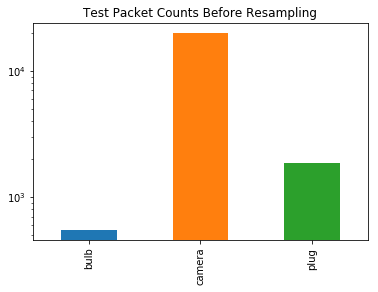

In [7]:
df_test = df[df['Set']=='test']

# Show initial test set imbalance
print "Initial test set distribution:"
print df_test['DeviceType'].value_counts()
df_test['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Before Resampling",logy=True);

In [8]:
# Downsample test set so that there is equal chance that the classifier will choose any given class
rds = RandomUnderSampler(random_state=42)
test_X_downsampled, test_y_downsampled = rds.fit_resample(df_test[features_list], df_test['DeviceType'])

# Show class counts after downsampling
unique, counts = np.unique(test_y_downsampled, return_counts=True)
print np.asarray((unique, counts)).T

[['bulb' 545]
 ['camera' 545]
 ['plug' 545]]


In [9]:
# Recreate df_test 
df_test_downsampled = pd.DataFrame(test_X_downsampled,columns=features_list)
df_test_downsampled['DeviceType'] = test_y_downsampled

# Run multiclass

In [10]:
multiclass_start = time.time()

preds, metrics, cms, feature_importance = w.run_multiclass(df_train, df_test_downsampled, features_list, y_list)

multiclass_end = time.time() - multiclass_start

# Report results

## Report confusion matrices

Confusion matrix, without normalization
[[527  13   5]
 [  0 344 201]
 [  0 102 443]]
Confusion matrix, without normalization
[[545   0   0]
 [  0 498  47]
 [  0 130 415]]
Confusion matrix, without normalization
[[545   0   0]
 [166 349  30]
 [103  15 427]]


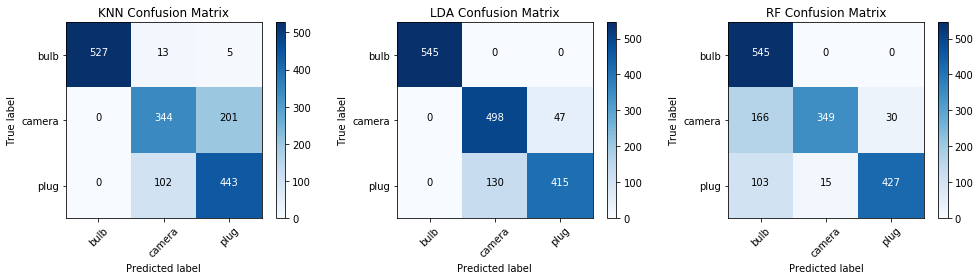

In [11]:
w.plot_all_confusion_matrices(cms, y_list)
plt.savefig('Results/CM/wifi-cm-full.png')

## Report metrics

In [12]:
metrics_df = w.report_metrics(metrics, y_list, 'wifi-multiclass_metrics')
display(metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
KNN,0.709202,0.810681,0.803670,1.000000,0.749455,0.682589,0.966972,0.631193,0.812844
RF,0.735601,0.854226,0.807951,0.669533,0.958791,0.934354,1.000000,0.640367,0.783486
LDA,0.840871,0.897087,0.891743,1.000000,0.792994,0.898268,1.000000,0.913761,0.761468


## Report feature importance

In [13]:
f_i = w.report_featureimportance(feature_importance, features_list)
display(f_i)

Belkin          0.53051
Assoc_Packets   0.28271
Dropcam         0.10328
PacketLength    0.03461
QoS_Null        0.02124
Data            0.01522
QoS_Data        0.00759
Lifi            0.00453
Tp-link         0.00031
dtype: float64

# Residuals Analysis

## Use only top 3 features

### Run multiclass with top 3 features

In [14]:
fs_start = time.time()
# Run multiclass with top 3 features
tf3_preds, tf3_metrics, tf3_cms, tf3_feature_importance = w.run_multiclass(df_train, df_test_downsampled, list(f_i.index[0:3]), y_list, use_tuned=False, use_priors=True)

fs_end = time.time() - fs_start

In [15]:
tf3_metrics_df = w.report_metrics(tf3_metrics, y_list, 'wifi-tf3_metrics')
display(tf3_metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
KNN,0.32470,0.42802,0.52538,0.42528,0.00781,0.85098,0.77798,0.00183,0.79633
RF,0.49356,0.48431,0.59939,0.48748,0.11111,0.85433,1.00000,0.00183,0.79633
LDA,0.59811,0.78955,0.71193,0.96654,0.54779,0.85433,0.47706,0.86239,0.79633


### Plot confusion matrices

Confusion matrix, without normalization
[[424 119   2]
 [470   1  74]
 [103   8 434]]
Confusion matrix, without normalization
[[260 285   0]
 [  1 470  74]
 [  8 103 434]]
Confusion matrix, without normalization
[[545   0   0]
 [470   1  74]
 [103   8 434]]


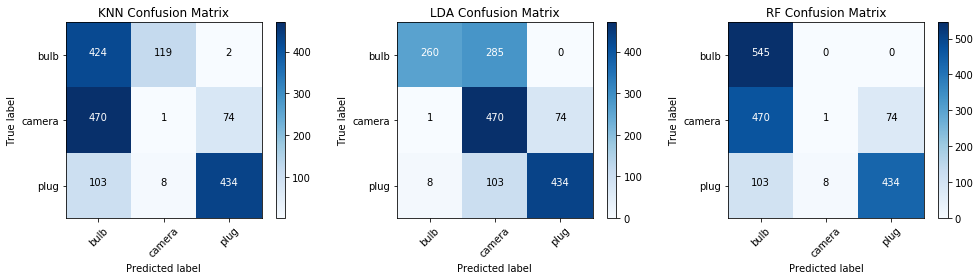

In [16]:
w.plot_all_confusion_matrices(tf3_cms, y_list)
plt.savefig('Results/CM/wifi-cm-best3.png')

### Report feature importance of 3 best

In [17]:
w.report_featureimportance(tf3_feature_importance, f_i.index[0:3])

Dropcam         0.59136
Assoc_Packets   0.29708
Belkin          0.11156
dtype: float64

## Remove vendor features

In [18]:
# Remove vendors features
nv_features = ['PacketLength', 'Data', 'QoS_Data', 'QoS_Null', 'Assoc_Packets']

In [19]:
nv_start = time.time()

# Run multiclass without vendors
nv_preds, nv_metrics, nv_cms, nv_feature_importance = w.run_multiclass(df_train, df_test_downsampled, nv_features, y_list, use_tuned=False)

nv_end = time.time() - nv_start

In [20]:
nv_metrics_df = w.report_metrics(nv_metrics, y_list, 'wifi-novendor_metrics')
display(nv_metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
KNN,0.44430,0.55882,0.60306,0.99413,0.21965,0.46267,0.93211,0.06972,0.80734
RF,0.44676,0.57910,0.60856,1.00000,0.27094,0.46638,0.93578,0.10092,0.78899
LDA,-0.04739,0.39759,0.30520,0.96296,0.22981,0.00000,0.47706,0.43853,0.00000


Confusion matrix, without normalization
[[508  33   4]
 [  0  38 507]
 [  3 102 440]]
Confusion matrix, without normalization
[[260 264  21]
 [  2 239 304]
 [  8 537   0]]
Confusion matrix, without normalization
[[510  33   2]
 [  0  55 490]
 [  0 115 430]]


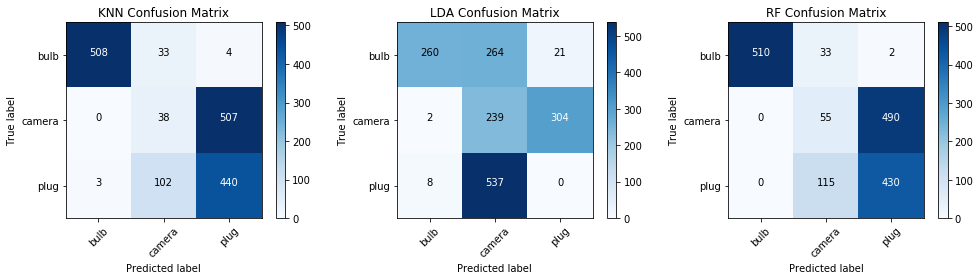

In [21]:
w.plot_all_confusion_matrices(nv_cms, y_list)
plt.savefig('Results/CM/wifi-cm-novendor.png')

In [22]:
w.report_featureimportance(nv_feature_importance, nv_features)

Assoc_Packets   0.90624
PacketLength    0.03605
Data            0.02689
QoS_Null        0.01562
QoS_Data        0.01520
dtype: float64

## Error analysis

In [23]:
def output_decisionpath(model, features_list, class_names, filename):
    # Source: https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

    # Extract single tree
    estimator = model.estimators_[5]

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = features_list,
                    class_names = class_names,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'Results/'+filename+'.png', '-Gdpi=600'])

**Error 1**: KNN and RF confuse camera and plugs

In [24]:
# Get camera and plug packets
df_train_camplugs = df_train[(df_train['DeviceType']=='camera') | (df_train['DeviceType']=='plug')]

df_test_camplugs = df_test_downsampled[(df_test_downsampled['DeviceType']=='camera') | (df_test_downsampled['DeviceType']=='plug')]

Isolate the two classes

In [25]:
# Run multiclass on just the two device types
camplugs_preds, camplugs_metrics, camplugs_cms, camplugs_feature_importance = w.run_multiclass(df_train_camplugs, df_test_camplugs, features_list, ['camera','plug'], use_tuned=False, use_priors=False)

In [26]:
camplugs_metrics_df = w.report_metrics(camplugs_metrics, ['camera','plug'], 'wifi-camplugs_metrics')
display(camplugs_metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Camera,Precision_Plug,Recall_Camera,Recall_Plug
KNN,-0.07908,0.45131,0.46789,0.42291,0.47972,0.17615,0.75963
RF,0.51092,0.75587,0.75505,0.77043,0.74132,0.72661,0.78349
LDA,0.12847,0.57027,0.55872,0.59877,0.54178,0.35596,0.76147


Confusion matrix, without normalization
[[ 96 449]
 [131 414]]
Confusion matrix, without normalization
[[194 351]
 [130 415]]
Confusion matrix, without normalization
[[396 149]
 [118 427]]


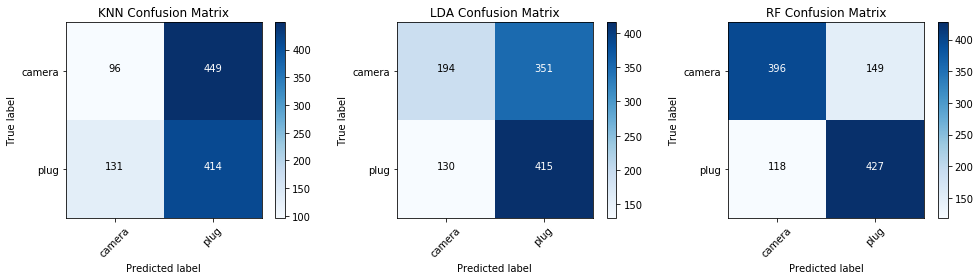

In [27]:
w.plot_all_confusion_matrices(camplugs_cms, ['camera','plug'])
plt.savefig('Results/CM/wifi-cm-camplug-full.png')

In [28]:
w.report_featureimportance(camplugs_feature_importance, features_list)

Belkin          0.45493
Dropcam         0.27327
Assoc_Packets   0.19212
QoS_Null        0.02715
PacketLength    0.02502
Data            0.02353
QoS_Data        0.00398
Tp-link         0.00000
Lifi            0.00000
dtype: float64

Show features

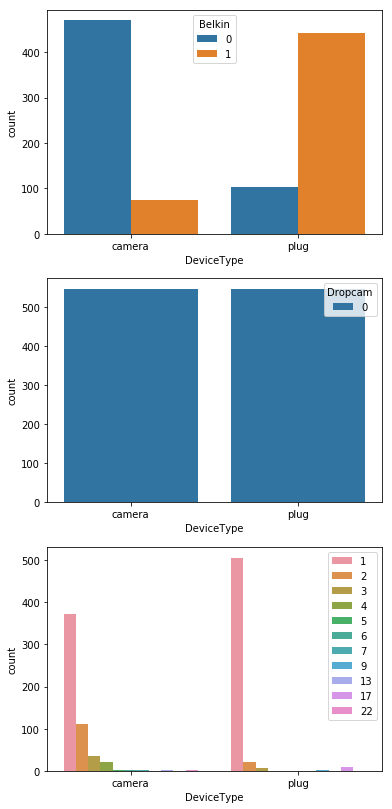

In [29]:
f, axes = plt.subplots(3, 1, figsize=(6, 14))
sns.countplot(x='DeviceType', hue='Belkin',ax=axes[0], data=df_test_camplugs);
sns.countplot(x='DeviceType', hue='Dropcam',ax=axes[1], data=df_test_camplugs);
sns.countplot(x='DeviceType', hue='Assoc_Packets',ax=axes[2], data=df_test_camplugs);
plt.legend(loc='upper right');

Use only top 3 features for camera vs plugs classification

In [30]:
# Run multiclass on just the two device types 
camplugs_preds_bf, camplugs_metrics_bf, camplugs_cms_bf, camplugs_feature_importance_bf= w.run_multiclass(df_train_camplugs, df_test_camplugs, ['Belkin','Dropcam','Assoc_Packets'], ['camera','plug'], use_tuned=False, use_priors=False)

In [31]:
camplugs_metrics__bf_df = w.report_metrics(camplugs_metrics_bf, ['camera','plug'], 'wifi-camplugs_bestfeatures_metrics')
display(camplugs_metrics__bf_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Camera,Precision_Plug,Recall_Camera,Recall_Plug
KNN,0.45768,0.73110,0.72661,0.76333,0.69887,0.65688,0.79633
RF,0.66208,0.83180,0.83028,0.80928,0.85433,0.86422,0.79633
LDA,0.04589,0.61479,0.50459,0.72727,0.50232,0.01468,0.99450


Confusion matrix, without normalization
[[358 187]
 [111 434]]
Confusion matrix, without normalization
[[  8 537]
 [  3 542]]
Confusion matrix, without normalization
[[471  74]
 [111 434]]


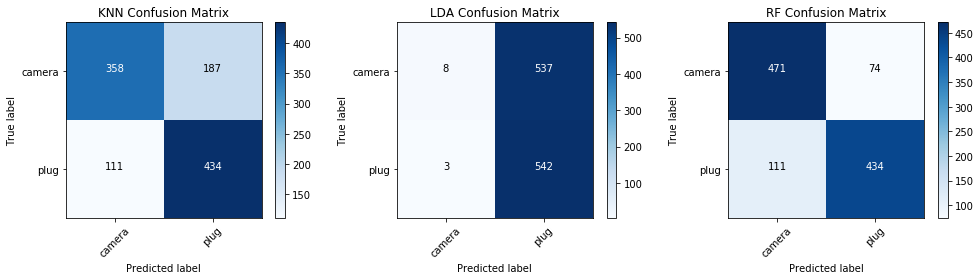

In [32]:
w.plot_all_confusion_matrices(camplugs_cms_bf, ['camera','plug'])
plt.savefig('Results/CM/wifi-cm-camplug-best3.png')

In [33]:
w.report_featureimportance(camplugs_feature_importance_bf, ['Belkin','Dropcam','Assoc_Packets'])

Assoc_Packets   0.58682
Belkin          0.30892
Dropcam         0.10426
dtype: float64

In [34]:
print multiclass_end
print fs_end
print nv_end
print time.time() - start_time

70.0993509293
11.3076469898
39.5369539261
487.031826973
